In [1]:
import pandas as pd
import os 
import numpy as np
import seaborn as sns
import collections
import csv
import missingno as msno
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest

%matplotlib inline

In [2]:
# read in the data
print (dt.datetime.now())
skip = ['price_cat','id','timestamp']
dir_path = os.getcwd() + '/../../../../data/all/'
df = pd.read_csv(dir_path + 'train.csv')
df_macro = pd.read_csv(dir_path + 'macro.csv')
print (dt.datetime.now())

2019-02-12 12:22:01.931556
2019-02-12 12:22:04.287407


In [3]:
df_eda = pd.merge(df, df_macro, how='inner', on='timestamp', left_on=None, right_on=None,
     left_index=False, right_index=False, sort=True,
     suffixes=('_x', '_y'), copy=True, indicator=False,
     validate=None)
df_eda.columns

Index(['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor',
       'material', 'build_year', 'num_room', 'kitch_sq',
       ...
       'provision_retail_space_modern_sqm', 'turnover_catering_per_cap',
       'theaters_viewers_per_1000_cap', 'seats_theather_rfmin_per_100000_cap',
       'museum_visitis_per_100_cap', 'bandwidth_sports',
       'population_reg_sports_share', 'students_reg_sports_share',
       'apartment_build', 'apartment_fund_sqm'],
      dtype='object', length=391)

In [4]:
num_cols = []
cat_cols = []
for col in df_eda.columns:
    if col not in skip:
        t = df_eda[col].dtype
        if t == 'float64' or t == 'int64':
            num_cols.append(col)
        else:
            cat_cols.append(col)
print(len(num_cols))
len(cat_cols)

371


18

In [5]:
bin_cols = []
for col in cat_cols:
    l = df_eda[col].describe().unique()
    if l[1] == 2:
        #print(col, ': ',l )
        #print(df_eda[col].value_counts())
        #print('')
        bin_cols.append(col)
cat_cols = [c for c in cat_cols if c not in bin_cols]
print(len(cat_cols))
len(bin_cols)

5


13

In [6]:
print (dt.datetime.now())
null_yr = 9999.0
yr = dt.datetime.now().year

idx = list(df_eda.loc[df_eda.build_year < 1700, 'build_year'].index)
idx += list(df_eda.loc[df_eda.build_year.isnull(), 'build_year'].index)
idx += list(df_eda.loc[df_eda.build_year > yr, 'build_year'].index)
print(len(idx))
df_eda.loc[idx, 'build_year'] = null_yr
print (dt.datetime.now())

2019-02-12 12:22:13.449925
14511
2019-02-12 12:22:13.657513


In [7]:
# create a new target variable called 'price_cat' for price category.
df_eda['price_length'] = [7.5 if cat > 6e6 and cat < 1e7 else len(str(cat)) for cat in df_eda['price_doc'] ]    
df_eda['price_length'] = [l if l < 8 else 8 for l in df_eda['price_length']]    
df_eda['price_cat'] = df_eda['price_length'].astype('category').cat.codes    

# there is only one record in price_cat 4, so make it a price_cat 3.
df_eda.loc[df_eda.price_cat == 4, 'price_cat'] = 3


In [8]:
df_eda.price_cat.value_counts()

1    13750
2    11678
3     4810
0      233
Name: price_cat, dtype: int64

In [9]:
#df_eda[num_cols].apply(lambda x: sum(x), axis=1) df_tmp[col].fillna(df_tmp[col].median(), inplace=True)
df_eda[num_cols] = df_eda[num_cols].fillna(df_eda[num_cols].median(), inplace=False)

In [10]:
df_eda[num_cols].head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,43,27.0,4.0,12.0,1.0,9999.0,2.0,6.0,2.0,6.407578e+06,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
1,34,19.0,3.0,12.0,1.0,9999.0,2.0,6.0,2.0,9.589337e+06,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
2,43,29.0,2.0,12.0,1.0,9999.0,2.0,6.0,2.0,4.808270e+06,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
3,89,50.0,9.0,12.0,1.0,9999.0,2.0,6.0,2.0,1.258354e+07,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
4,77,77.0,4.0,12.0,1.0,9999.0,2.0,6.0,2.0,8.398461e+06,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0


In [11]:
for col in bin_cols:
    df_eda[col] = df_eda[col].astype('category').cat.codes
    df_eda[col].head()
df_eda[bin_cols].head()

,product_type,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,1,0,0,0,0,0,1


In [12]:
for col in cat_cols:
    df_eda = pd.merge(df_eda, pd.get_dummies(df_eda[col].astype('category').cat.codes, prefix=col)\
                         ,left_index=True, right_index=True)
    df_eda.drop([col],inplace=True, axis=1)
df_eda.shape

(30471, 552)

In [13]:
df_eda.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,child_on_acc_pre_school_2,child_on_acc_pre_school_3,modern_education_share_-1,modern_education_share_0,modern_education_share_1,modern_education_share_2,old_education_build_share_-1,old_education_build_share_0,old_education_build_share_1,old_education_build_share_2
0,1,2011-08-20,43,27.0,4.0,12.0,1.0,9999.0,2.0,6.0,...,0,0,1,0,0,0,1,0,0,0
1,2,2011-08-23,34,19.0,3.0,12.0,1.0,9999.0,2.0,6.0,...,0,0,1,0,0,0,1,0,0,0
2,3,2011-08-27,43,29.0,2.0,12.0,1.0,9999.0,2.0,6.0,...,0,0,1,0,0,0,1,0,0,0
3,4,2011-09-01,89,50.0,9.0,12.0,1.0,9999.0,2.0,6.0,...,0,0,1,0,0,0,1,0,0,0
4,5,2011-09-05,77,77.0,4.0,12.0,1.0,9999.0,2.0,6.0,...,0,0,1,0,0,0,1,0,0,0


In [14]:
rest_cols = [c for c in df_eda.columns if c not in num_cols]

In [15]:
km_list = ['additional_education_km', 'basketball_km', 'big_church_km', 'big_market_km', 'big_road1_km', \
           'big_road2_km', 'bulvar_ring_km', 'bus_terminal_avto_km', 'catering_km', 'cemetery_km', \
           'church_synagogue_km', 'detention_facility_km', 'exhibition_km', 'fitness_km', 'green_zone_km', \
           'hospice_morgue_km', 'ice_rink_km', 'incineration_km', 'industrial_km', 'kindergarten_km', 'kremlin_km', \
           'market_shop_km', 'metro_km_avto', 'metro_km_walk', 'mkad_km', 'mosque_km', 'museum_km',\
           'nuclear_reactor_km', 'office_km', 'oil_chemistry_km', 'park_km', 'power_transmission_line_km',\
           'preschool_km', 'public_healthcare_km', 'public_transport_station_km', 'radiation_km', 'railroad_km', \
           'railroad_station_avto_km', 'railroad_station_walk_km', 'sadovoe_km', 'school_km', 'shopping_centers_km', \
           'stadium_km', 'swim_pool_km', 'theater_km', 'thermal_power_plant_km', 'ts_km', 'ttk_km', \
           'university_km', 'water_km', 'water_treatment_km', 'workplaces_km', 'zd_vokzaly_avto_km']
len(km_list)

53

In [16]:
# continous numeric data scaled ... 
print (dt.datetime.now())
scaler = StandardScaler()
df_new = pd.merge(pd.DataFrame(scaler.fit_transform(df_eda[num_cols]), columns=num_cols), \
                  df_eda[rest_cols],left_index=True, right_index=True)

df_new['build_year'] = df_eda['build_year']

df_new['diff_sq'] = df_new['full_sq'] - df_new['kitch_sq']
df_new['plus_sq'] = df_new['full_sq'] + df_new['life_sq'] 


print(df_new.head())
print (dt.datetime.now())


2019-02-12 12:22:43.142770
    full_sq   life_sq     floor  max_floor  material  build_year  num_room  \
0 -0.294873 -0.139309 -0.690611  -0.068443 -0.441371      9999.0  0.087541   
1 -0.531523 -0.311273 -0.879077  -0.068443 -0.441371      9999.0  0.087541   
2 -0.294873 -0.096319 -1.067542  -0.068443 -0.441371      9999.0  0.087541   
3  0.914671  0.355086  0.251717  -0.068443 -0.441371      9999.0  0.087541   
4  0.599138  0.935463 -0.690611  -0.068443 -0.441371      9999.0  0.087541   

   kitch_sq     state    area_m    ...     modern_education_share_-1  \
0 -0.011699 -0.090296 -0.544788    ...                             1   
1 -0.011699 -0.090296 -0.390702    ...                             1   
2 -0.011699 -0.090296 -0.622239    ...                             1   
3 -0.011699 -0.090296 -0.245700    ...                             1   
4 -0.011699 -0.090296 -0.448374    ...                             1   

   modern_education_share_0  modern_education_share_1  \
0             

In [17]:
df_new.shape

(30471, 554)

In [18]:
best_cols = []
for col in df_new.columns:
#for col in rest_cols:
    if col not in skip+['price_length', 'price_doc']:
        #print(col)
        cr = np.corrcoef(df_new.loc[:, col], df_new.loc[:,'price_cat'])
        best_cols.append(((np.abs(cr[1][0]),cr[1][0]),col))
        #print(col,": ",cr[1][0])
        #print(list(zip(mutual_info_classif(df_new.loc[:,['price_cat',col]], \
        #                                   df_new.loc[:,'price_cat'], discrete_features=False), ['price_cat',col])))
                        
sorted(best_cols,reverse=True)[:50]

/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


[((0.42272655227276296, 0.42272655227276296), 'num_room'),
 ((0.3228114350581882, -0.3228114350581882), 'zd_vokzaly_avto_km'),
 ((0.3119372565397539, -0.3119372565397539), 'sadovoe_km'),
 ((0.3102738444428206, -0.3102738444428206), 'nuclear_reactor_km'),
 ((0.30868951333548567, -0.30868951333548567), 'ttk_km'),
 ((0.3080194544479649, 0.3080194544479649), 'trc_count_5000'),
 ((0.3067170967400468, -0.3067170967400468), 'bulvar_ring_km'),
 ((0.3049298129939774, -0.3049298129939774), 'kremlin_km'),
 ((0.2998198942018067, -0.2998198942018067), 'ecology_2'),
 ((0.29578375903626536, 0.29578375903626536), 'sport_count_5000'),
 ((0.2920133356661141, 0.2920133356661141), 'trc_sqm_5000'),
 ((0.2879056919203073, 0.2879056919203073), 'sport_count_3000'),
 ((0.28547946500356763, 0.28547946500356763), 'full_sq'),
 ((0.2826455285687625, 0.2826455285687625), 'sport_count_2000'),
 ((0.2816627496017344, -0.2816627496017344), 'stadium_km'),
 ((0.2815093375475934, -0.2815093375475934), 'detention_facility_

In [19]:
sorted(best_cols,reverse=True)[:200]

[((0.42272655227276296, 0.42272655227276296), 'num_room'),
 ((0.3228114350581882, -0.3228114350581882), 'zd_vokzaly_avto_km'),
 ((0.3119372565397539, -0.3119372565397539), 'sadovoe_km'),
 ((0.3102738444428206, -0.3102738444428206), 'nuclear_reactor_km'),
 ((0.30868951333548567, -0.30868951333548567), 'ttk_km'),
 ((0.3080194544479649, 0.3080194544479649), 'trc_count_5000'),
 ((0.3067170967400468, -0.3067170967400468), 'bulvar_ring_km'),
 ((0.3049298129939774, -0.3049298129939774), 'kremlin_km'),
 ((0.2998198942018067, -0.2998198942018067), 'ecology_2'),
 ((0.29578375903626536, 0.29578375903626536), 'sport_count_5000'),
 ((0.2920133356661141, 0.2920133356661141), 'trc_sqm_5000'),
 ((0.2879056919203073, 0.2879056919203073), 'sport_count_3000'),
 ((0.28547946500356763, 0.28547946500356763), 'full_sq'),
 ((0.2826455285687625, 0.2826455285687625), 'sport_count_2000'),
 ((0.2816627496017344, -0.2816627496017344), 'stadium_km'),
 ((0.2815093375475934, -0.2815093375475934), 'detention_facility_

In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import csv
from xgboost import XGBClassifier
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import model_selection



/Users/chadleonard/Springboard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [21]:
slist = [c for c in df_new.columns if c not in skip+['price_doc','price_length']]

In [27]:
print(len(slist))

549


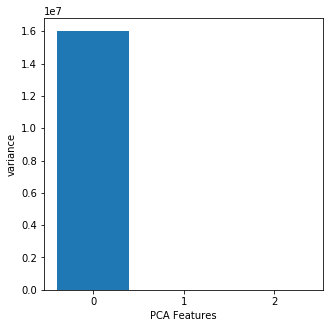

In [29]:
model = PCA(n_components=3)
model.fit(df_new[slist])
model.transform(df_new[slist])

fig, ax = plt.subplots(figsize=(5,5))

features = range(model.n_components_)

plt.bar(features, model.explained_variance_)
plt.xticks(features)
plt.xlabel('PCA Features')
plt.ylabel('variance')
plt.show()

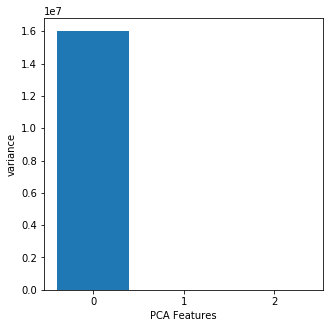

In [33]:
model = TruncatedSVD(n_components=3)
model.fit(df_new[num_cols])
model.transform(df_new[num_cols])

fig, ax = plt.subplots(figsize=(5,5))

features = range(model.n_components)

plt.bar(features, model.explained_variance_)
plt.xticks(features)
plt.xlabel('PCA Features')
plt.ylabel('variance')
plt.show()

In [35]:
model = NMF(n_components=3)
model.fit(df_new[num_cols])
model.transform(df_new[num_cols])

fig, ax = plt.subplots(figsize=(5,5))

features = range(model.n_components)

plt.bar(features, model.explained_variance_)
plt.xticks(features)
plt.xlabel('PCA Features')
plt.ylabel('variance')
plt.show()

ValueError: Negative values in data passed to NMF (input X)

In [22]:
idx0 = df_new[df_new['price_cat'] == 0].index
idx1 = df_new[df_new['price_cat'] == 1].index
idx2 = df_new[df_new['price_cat'] == 2].index
idx3 = df_new[df_new['price_cat'] == 3].index
print(len(idx0))
print(len(idx1))
print(len(idx2))
print(len(idx3))

233
13750
11678
4810


In [23]:
idx_list = list(df_new.loc[idx1].sample(len(idx3)).index) + \
list(df_new.loc[idx2].sample(len(idx3)).index) + \
list(df_new.loc[idx3].sample(len(idx3)).index) + \
list(df_new.loc[idx0].sample(len(idx0)).index)

len(idx_list)

14663

In [24]:
#x_list = ig_list
X_train, X_test, y_train, y_test = model_selection.train_test_split(df_new.loc[idx_list, slist], \
                                                                df_new.loc[idx_list, 'price_cat'], test_size=0.3)
X_train.shape

(10264, 549)

### Feature Selection

In [25]:
import xgboost as xgb

In [158]:
xlist = ['full_sq', 'plus_sq', 'diff_sq', 'floor', 'num_room', 'max_floor', 'material', 'build_year', 
         'state', 'green_zone_part', 'indust_part', 'school_education_centers_top_20_raion', 'hospital_beds_raion',
         'healthcare_centers_raion', 'university_top_20_raion', 'sport_objects_raion', 'additional_education_raion',
         'shopping_centers_raion', 'build_count_block', 'build_count_frame', 'build_count_brick', 'build_count_foam',
         'build_count_1946-1970', 'build_count_1971-1995', 'ID_metro', 'green_zone_km', 'industrial_km',
         'water_treatment_km', 'cemetery_km', 'incineration_km', 'railroad_station_walk_km', 
         'railroad_station_walk_min', 'ID_railroad_station_walk', 'railroad_station_avto_km', 
         'railroad_station_avto_min', 'ID_railroad_station_avto', 'public_transport_station_km', 
         'public_transport_station_min_walk', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km', 
         'kremlin_km', 'big_road1_km', 'ID_big_road1', 'big_road2_km', 'ID_big_road2', 'railroad_km', 
         'zd_vokzaly_avto_km', 'ID_railroad_terminal', 'bus_terminal_avto_km', 'ID_bus_terminal', 'oil_chemistry_km',
         'nuclear_reactor_km', 'radiation_km', 'power_transmission_line_km', 'thermal_power_plant_km', 'ts_km',
         'big_market_km', 'market_shop_km', 'fitness_km', 'swim_pool_km', 'ice_rink_km', 'stadium_km', 
         'basketball_km', 'hospice_morgue_km', 'detention_facility_km']
xlist[:5]

['full_sq', 'plus_sq', 'diff_sq', 'floor', 'num_room']

2019-02-09 15:35:36.996245
2019-02-09 15:36:04.440813


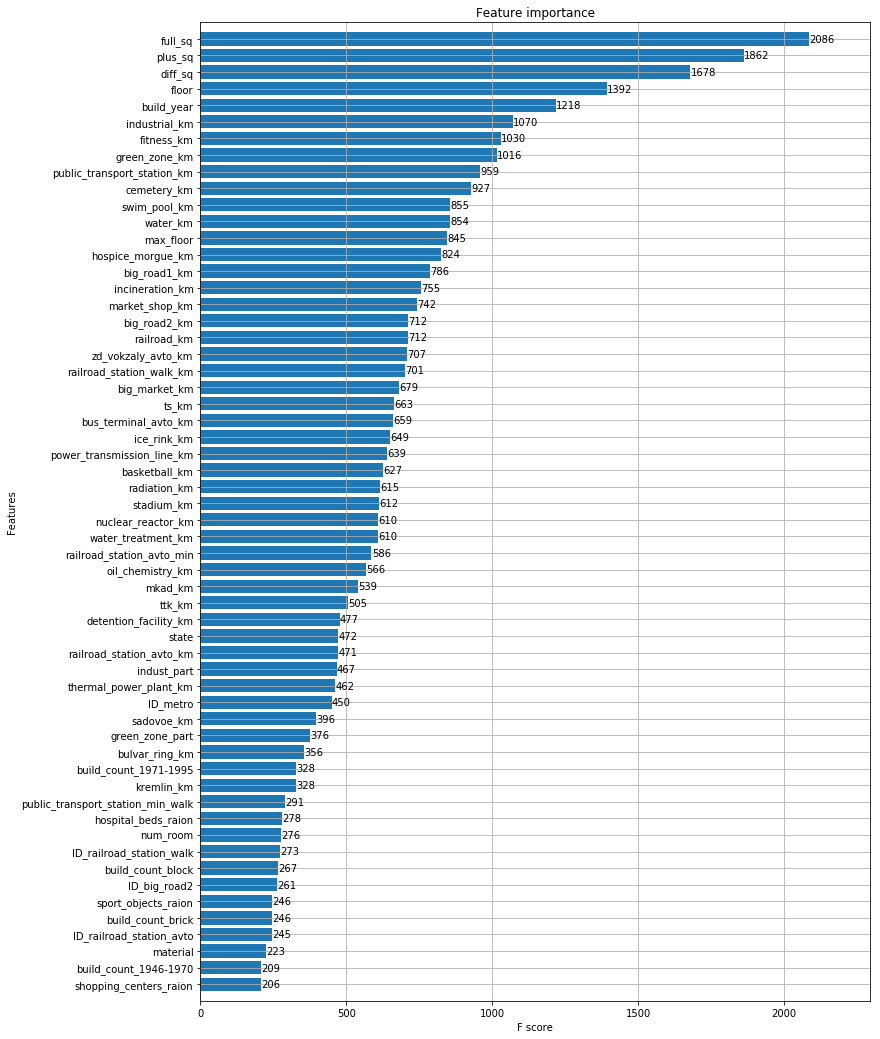

In [163]:
print (dt.datetime.now())    
#for f in X_train.columns:
for f in xlist:
    if X_train[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values)) 
        X_train[f] = lbl.transform(list(X_train[f].values))
        
train_y = y_train
train_X = X_train.loc[:,xlist]

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
     'num_class': 4,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'multi:softmax',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=100)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=58, height=0.8, ax=ax)
print (dt.datetime.now())    
plt.show()

In [162]:
'university_top_20_raion' in xlist

True

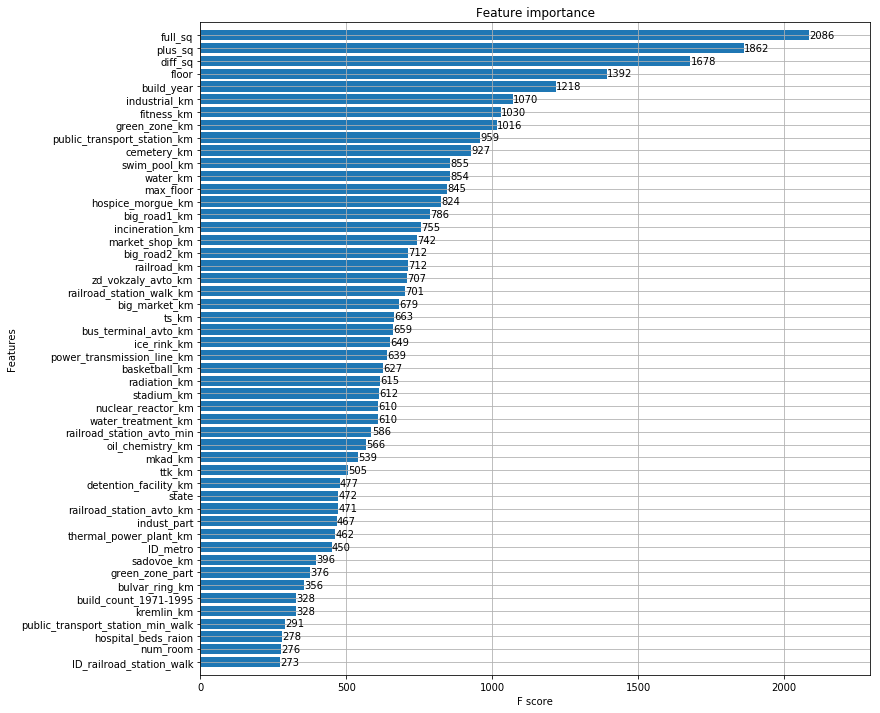

In [175]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model,max_num_features=50, height=0.8, ax=ax)
plt.show()
fig.savefig('plot.png')

In [174]:
from sklearn.feature_selection import VarianceThreshold
X_tr = X_train[xlist]
selector = VarianceThreshold(threshold=(.5 * (1 - .5)))
selector.fit(X_tr, y_train)

# Retain the feature names
features = selector.get_support(indices = True)  # Returns array of indexes of nonremoved features
features = [column for column in X_tr.iloc[:,features]]  # Gets feature names

# Transform, Format, Return
selector = pd.DataFrame(selector.transform(X_tr))
selector.columns = features
selector.head()

,full_sq,plus_sq,diff_sq,floor,num_room,max_floor,material,build_year,state,green_zone_part,...,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km
0,-0.347462,-0.422285,-0.122171,0.251717,-1.327560,0.824183,-0.441371,9999.0,-1.610420,1.564463,...,0.224469,0.019424,1.643543,0.463761,0.491892,0.123900,0.309462,1.071070,0.780937,1.422599
1,-0.373756,-0.233625,-0.362057,-0.690611,0.087541,-0.068443,-0.441371,9999.0,-0.090296,1.564463,...,0.224469,0.019424,1.643543,0.463761,0.491892,0.123900,0.309462,1.071070,0.780937,1.422599
2,-0.452639,-0.763912,-0.440940,-1.067542,0.087541,-0.068443,-0.441371,9999.0,-0.090296,-0.488610,...,-0.681830,-0.201133,-0.266938,-0.086431,0.016717,0.074570,-0.565935,-0.506887,-0.425410,-0.274199
3,-0.426345,-0.737618,-0.414646,0.440183,0.087541,-0.068443,-0.441371,9999.0,-0.090296,-0.700520,...,-0.563857,-0.609294,-0.722662,-0.459261,-0.208706,-1.153896,-0.442441,-0.231282,0.464062,-0.963543
4,0.835788,1.900223,0.548459,-0.313680,1.502642,-2.032221,-0.441371,2015.0,-1.610420,-0.014631,...,-0.831344,0.578435,0.236715,-0.653547,-0.039350,-0.858351,-0.244889,-0.545213,-0.146635,-0.836196


In [30]:
l = [k for k,v in model.get_fscore().items()]
not_in_l = []
for f in features:
    if f not in l:
        not_in_l.append(f)
len(not_in_l)

51

In [29]:
n=0
not_in_features = []
for k,v in model.get_fscore().items():
    if k in features:
        n+=1
    else:
        not_in_features.append(k)
        
print(len(not_in_features))
print(n)
len(features)

88
318


369

In [ ]:
print (dt.datetime.now())
h = .02  # step size in the mesh

names = [#"Nearest Neighbors",  
         #"RBF SVM", 
         #"Gaussian Process",
         #"Extra Tree Clf",
         "Gradient Boost Clf",
         #"Ridge Classifier",
         #"Logistic Reg Multi",
         #"SGD",
         "Decision Tree", 
         "Random Forest" ,
         "Random Forest Two" 
         #"Neural Net: adam"
         #"Neural N: lbfgs",
         #"Neural Net: tanh",
         #"AdaBoost"
         #"Linear SVM"
         #"QDA"
        ]

classifiers = [
    #KNeighborsClassifier(7),
    #ExtraTreesClassifier(n_estimators=100),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,max_depth=5, random_state=0),
    #RidgeClassifier(),
    #LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),
    #SGDClassifier(loss="hinge", penalty="l2", max_iter=5),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=100),
    RandomForestClassifier(max_depth=20, n_estimators=200)
    #MLPClassifier(alpha=0.1,hidden_layer_sizes=(547,500,500,500,500,)),
    #MLPClassifier(alpha=1,hidden_layer_sizes=(100,100,), solver='lbfgs'),
    #MLPClassifier(alpha=1,hidden_layer_sizes=(100,100,), activation='tanh'),
    #AdaBoostClassifier()
    #SVC(kernel="linear", C=0.025)
    #GaussianNB(),
    #QuadraticDiscriminantAnalysis()
    ]

score_dict = dict()
score_list = []
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print(name)
    train_score = clf.score(X_train,y_train)
    print("train score: ", train_score)    
    test_score = clf.score(X_test, y_test)
    print("test score: ", str(test_score))
    score_dict.update({test_score: (name, train_score)})
    print (dt.datetime.now())
    print('='*10)


od = collections.OrderedDict(sorted(score_dict.items(),reverse=True))    

print (dt.datetime.now())
#print(slist)
od
#plt.tight_layout()
#plt.show()

In [78]:
features

['full_sq',
 'floor',
 'max_floor',
 'material',
 'build_year',
 'num_room',
 'state',
 'area_m',
 'raion_popul',
 'green_zone_part',
 'indust_part',
 'children_preschool',
 'preschool_quota',
 'preschool_education_centers_raion',
 'children_school',
 'school_quota',
 'school_education_centers_raion',
 'school_education_centers_top_20_raion',
 'hospital_beds_raion',
 'healthcare_centers_raion',
 'university_top_20_raion',
 'sport_objects_raion',
 'additional_education_raion',
 'culture_objects_top_25_raion',
 'shopping_centers_raion',
 'office_raion',
 'full_all',
 'male_f',
 'female_f',
 'young_all',
 'young_male',
 'young_female',
 'work_all',
 'work_male',
 'work_female',
 'ekder_all',
 'ekder_male',
 'ekder_female',
 '0_6_all',
 '0_6_male',
 '0_6_female',
 '7_14_all',
 '7_14_male',
 '7_14_female',
 '0_17_all',
 '0_17_male',
 '0_17_female',
 '16_29_all',
 '16_29_male',
 '16_29_female',
 '0_13_all',
 '0_13_male',
 '0_13_female',
 'raion_build_count_with_material_info',
 'build_count_

In [81]:
flist = ['full_sq','plus_sq','diff_sq','floor','num_room','max_floor']

In [108]:
fl = []
for f in features[100:120]:
    if f not in flist:
        flist.append(f)

        # final model
        print (dt.datetime.now())    
        dtrain = xgb.DMatrix(X_train[flist], y_train, feature_names=flist)
        #dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns.values)
        model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=100)

        xg_test = xgb.DMatrix(X_test[flist], label=y_test)
        #xg_test = xgb.DMatrix(X_test, label=y_test)
        pred = model.predict(xg_test)
        error_rate = np.sum(pred != y_test) / y_test.shape[0]
        accuracy = np.sum(pred == y_test) / y_test.shape[0]
        fl.append((accuracy,error_rate))
        #print('Test error using softmax = {}'.format(error_rate))
        #print('Test accuracy using softmax = {}'.format(accuracy))
print(sorted(fl,reverse=True)[:5])
print (dt.datetime.now()) 

2019-02-09 12:21:07.133335
2019-02-09 12:21:41.499567
2019-02-09 12:22:15.754278
2019-02-09 12:22:50.413145
2019-02-09 12:23:25.393853
2019-02-09 12:24:00.219592
2019-02-09 12:24:35.903932
2019-02-09 12:25:12.044687
2019-02-09 12:25:49.161262
2019-02-09 12:26:26.445260
2019-02-09 12:27:04.732227
2019-02-09 12:27:43.312370
2019-02-09 12:28:23.625015
2019-02-09 12:29:03.945298
2019-02-09 12:29:44.074767
2019-02-09 12:30:23.642348
2019-02-09 12:31:04.834546
2019-02-09 12:31:46.724044
2019-02-09 12:32:27.711724
2019-02-09 12:33:09.626734
[(0.8190497840418277, 0.18095021595817232), (0.8188224596499204, 0.18117754035007957), (0.8185951352580132, 0.1814048647419868), (0.8185951352580132, 0.1814048647419868), (0.8185951352580132, 0.1814048647419868)]
2019-02-09 12:33:52.244754


In [157]:
print(flist)

['full_sq', 'plus_sq', 'diff_sq', 'floor', 'num_room', 'max_floor', 'material', 'build_year', 'state', 'green_zone_part', 'indust_part', 'school_education_centers_top_20_raion', 'hospital_beds_raion', 'healthcare_centers_raion', 'university_top_20_raion', 'sport_objects_raion', 'additional_education_raion', 'shopping_centers_raion', 'build_count_block', 'build_count_frame', 'build_count_brick', 'build_count_foam', 'build_count_1946-1970', 'build_count_1971-1995', 'ID_metro', 'green_zone_km', 'industrial_km', 'water_treatment_km', 'cemetery_km', 'incineration_km', 'railroad_station_walk_km', 'railroad_station_walk_min', 'ID_railroad_station_walk', 'railroad_station_avto_km', 'railroad_station_avto_min', 'ID_railroad_station_avto', 'public_transport_station_km', 'public_transport_station_min_walk', 'water_km', 'mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km', 'kremlin_km', 'big_road1_km', 'ID_big_road1', 'big_road2_km', 'ID_big_road2', 'railroad_km', 'zd_vokzaly_avto_km', 'ID_railroad

In [74]:
'full_sq' in flist

True

In [ ]:
alg = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

In [153]:
# final model
print (dt.datetime.now())    
dtrain = xgb.DMatrix(X_train[flist], y_train, feature_names=flist)
#dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns.values)
model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=100)

xg_test = xgb.DMatrix(X_test[flist], label=y_test)
#xg_test = xgb.DMatrix(X_test, label=y_test)
pred = model.predict(xg_test)
error_rate = np.sum(pred != y_test) / y_test.shape[0]
accuracy = np.sum(pred == y_test) / y_test.shape[0]
print('Test error using softmax = {}'.format(error_rate))
print('Test accuracy using softmax = {}'.format(accuracy))
print (dt.datetime.now()) 

2019-02-09 14:04:21.277500
Test error using softmax = 0.18367810866105932
Test accuracy using softmax = 0.8163218913389406
2019-02-09 14:04:48.747141


In [182]:
df_new['foot_per_floor_sq'] = df_new['full_sq'] / df_new['max_floor']
df_new['foot_per_floor_sq'].head()

0     4.308288
1     7.765900
2     4.308288
3   -13.363951
4    -8.753802
Name: foot_per_floor_sq, dtype: float64

In [183]:
np.corrcoef(df_new['foot_per_floor_sq'], df_new['price_cat'])

array([[ 1.        , -0.11044121],
       [-0.11044121,  1.        ]])

In [95]:
cor_matrix = np.corrcoef(df_new[flist].T)

In [110]:
d = {}
for j in range(cor_matrix.shape[0]):
    lst = []
    for i in range(cor_matrix.shape[0]):
        t = cor_matrix[j][i]
        if t > .8 and flist[j] != flist[i]:
            #print(i)
            #print(t)
            lst.append((flist[i],t))
    if lst != []:
        d.update({flist[j]:lst})
d

{'area_m': [('kindergarten_km', 0.8021176531250173)],
 'raion_popul': [('children_preschool', 0.9540021242742965),
  ('preschool_education_centers_raion', 0.8443841121644792),
  ('children_school', 0.9570166756255344),
  ('school_education_centers_raion', 0.8250720570128619),
  ('young_all', 0.9593282427801422),
  ('young_male', 0.9584955293864319),
  ('young_female', 0.958279470544675),
  ('work_all', 0.996598316522335),
  ('work_male', 0.9941220235748757),
  ('work_female', 0.9938295533480695),
  ('ekder_all', 0.9536719140425647),
  ('ekder_male', 0.9274718876446157),
  ('ekder_female', 0.960803665682533),
  ('0_6_all', 0.9540021242742971),
  ('0_6_male', 0.9532357068944277),
  ('0_6_female', 0.9530814413833748),
  ('7_14_all', 0.9570166756255345),
  ('7_14_male', 0.9569778846803625),
  ('7_14_female', 0.9538758453499602),
  ('0_17_all', 0.961737353285288),
  ('0_17_male', 0.9606721953793341),
  ('0_17_female', 0.96105029684097),
  ('0_13_all', 0.9582589034381829),
  ('0_13_male', 0.

In [186]:
for c in d['0_13_female']:
    print(c[0])

raion_popul
children_preschool
preschool_education_centers_raion
children_school
school_education_centers_raion
young_all
young_male
young_female
work_all
work_male
work_female
ekder_all
ekder_male
ekder_female
0_6_all
0_6_male
0_6_female
7_14_all
7_14_male
7_14_female
0_17_all
0_17_male
0_17_female
0_13_all
0_13_male


In [152]:
print(len(flist))
print(len(d.keys()))

l = []
for a in list(d.values()):
    for b in a:
        #print(b[0])
        l.append(b[0])
l = list(set(l))
flist = [z for z in flist if  z not in l]
len(flist)

122
54


68